# Exercises

# These exercises should go in a notebook or script named explore.

# Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

In [16]:
#### import
import wrangle

import warnings
warnings.filterwarnings('ignore')

import pyspark.sql
from pyspark.sql.functions import *

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle.wrangle_311(spark)

[wrangle.py] reading case.csv


[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features


[wrangle.py] joining departments


# How many different cases are there, by department?

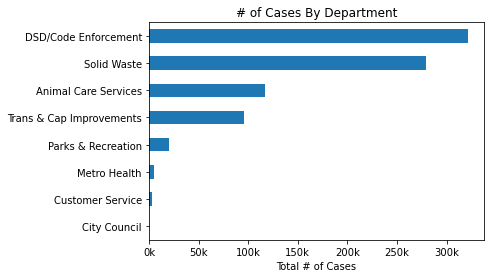

In [18]:
def format_number(x, *args):
    return "{:.0f}k".format(x / 1000)


(
    df.groupby("department")
    .count()
    .toPandas()
    .set_index("department")["count"]
    .sort_values()
    .plot.barh()
)
plt.gca().set(
    ylabel="", xlabel="Total # of Cases", title="# of Cases By Department"
)
plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter(format_number))

# Does the percentage of cases that are late vary by department?

[Text(0, 0.5, ''),
 Text(0.5, 0, '% of Cases Closed After Due Date'),
 Text(0.5, 1.0, '% of Late Cases By Department')]

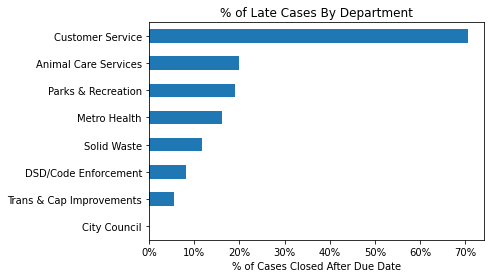

In [19]:
(
    df.withColumn("case_late", col("case_late").cast("int"))
    .groupby("department")
    .agg(avg("case_late").alias("p_cases_late"))
    .toPandas()
    .set_index("department")
    .p_cases_late.sort_values()
    .plot.barh()
)
plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter("{:.0%}".format))
plt.gca().set(
    ylabel="",
    xlabel="% of Cases Closed After Due Date",
    title="% of Late Cases By Department",
)

# On average, how late are the late cases by department?

[Text(0, 0.5, ''),
 Text(0.5, 0, 'Avg # of Days Late'),
 Text(0.5, 1.0, 'How late are the late cases?')]

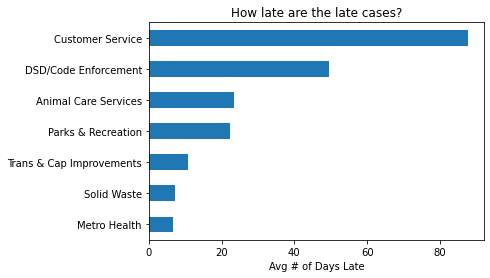

In [20]:
(
    df.filter("case_late")
    .groupby("department")
    .agg(avg("num_days_late").alias("avg_days_late"))
    .toPandas()
    .set_index("department")
    .avg_days_late.sort_values()
    .plot.barh()
)

plt.gca().set(
    ylabel="",
    xlabel="Avg # of Days Late",
    title="How late are the late cases?",
)

# What is the service type that is the most late? Just for Parks & Rec?

[Text(0.5, 1.0, 'Most Late Cases For Parks & Recreation'),
 Text(0.5, 0, '# of Days Late'),
 Text(0, 0.5, '')]

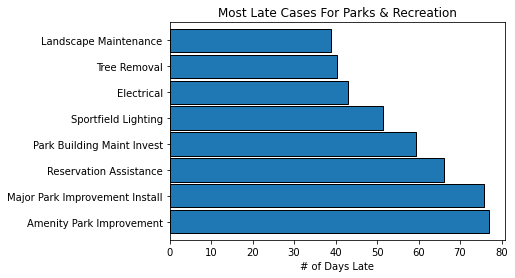

In [21]:
(
    df.filter(df.case_late)
    .filter(df.department == "Parks & Recreation") # comment out this line to see all
    .groupby("service_request_type")
    .agg(mean("num_days_late").alias("avg_days_late"))
    .sort(desc("avg_days_late"))
    .limit(8)  # limit in spark, not pandas
    .toPandas()
    .set_index("service_request_type")
    .avg_days_late
    .plot.barh(ec="black", width=0.9)
)

plt.gca().set(
    title="Most Late Cases For Parks & Recreation",
    xlabel="# of Days Late",
    ylabel="",
)

# For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

[Text(0, 0.5, ''),
 Text(0.5, 0, '# of Requests'),
 Text(0.5, 1.0, 'Most Common Service Request Types for Parks & Recreation')]

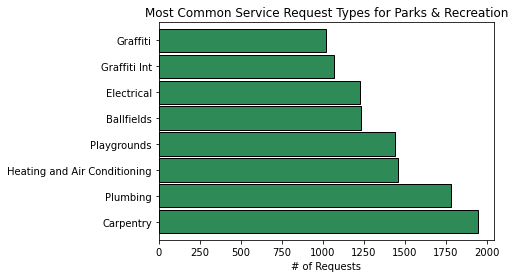

In [22]:
def format_number_sub_thousands(x, *args):
    return "{:.0f}k".format(x / 1000)
(
    # comment out / switch the filter statement to view different departments
#     df.filter(expr('department == "DSD/Code Enforcement"'))
    df.filter(expr('department == "Parks & Recreation"'))    
    .groupby("service_request_type")
    .count()
    .sort(desc("count"))
    .limit(8)
    .toPandas()
    .set_index("service_request_type")["count"]
    .plot.barh(color="seagreen", width=0.9, ec="black")
)

plt.gca().set(
    ylabel="",
    xlabel="# of Requests",
    title="Most Common Service Request Types for Parks & Recreation",
)

# Does whether or not its a weekend matter for when a case is opened/closed?

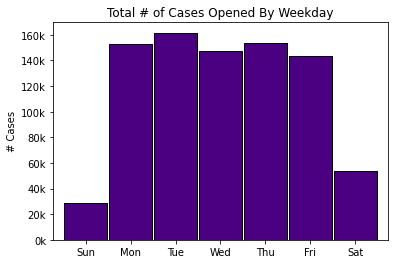

In [23]:
weekdays = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

(
    df.withColumn("weekday", date_format("case_opened_date", "E"))
    # the line above is an example of doing the date formatting with spark
    # through the SimpleDateFormat api instead of with python
    .groupby("weekday")
    .count()
    .na.drop()
    .toPandas()
    # Here we convert the weekday string to a categorical type with an order.
    # This lets us order the weekdays properly in our visualization.
    .assign(weekday=lambda df: pd.Categorical(df.weekday, categories=weekdays, ordered=True))
    .set_index("weekday")["count"]
    .sort_index()
    .plot.bar(width=0.95, ec="black", color="indigo")
)

plt.xticks(rotation=0)
plt.gca().set(
    xlabel="", ylabel="# Cases", title="Total # of Cases Opened By Weekday"
)
plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(format_number_sub_thousands))

# On average, how many cases are opened a day for the Customer Service department?

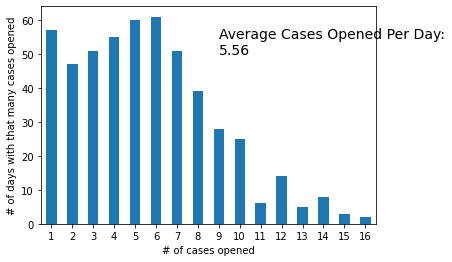

In [24]:
def plot_cases(df):
    s = df["count"]
    avg = s.mean()
    s.value_counts().sort_index().plot.bar()
    plt.text(
        8, 50, f"Average Cases Opened Per Day:\n{avg:.2f}", ha="left", size=14
    )
    plt.xlabel("# of cases opened")
    plt.ylabel("# of days with that many cases opened")
    plt.xticks(rotation=0)


(
    df.withColumn("case_opened_date", expr("date(case_opened_date)"))
    .filter(df.department == "Customer Service")
    .groupby("case_opened_date")
    .count()
    .toPandas()
    # .pipe takes our data frame and "pipes" the dataframe into a function
    .pipe(plot_cases)
)

# Does the number of service requests for the solid waste department vary by day of the 

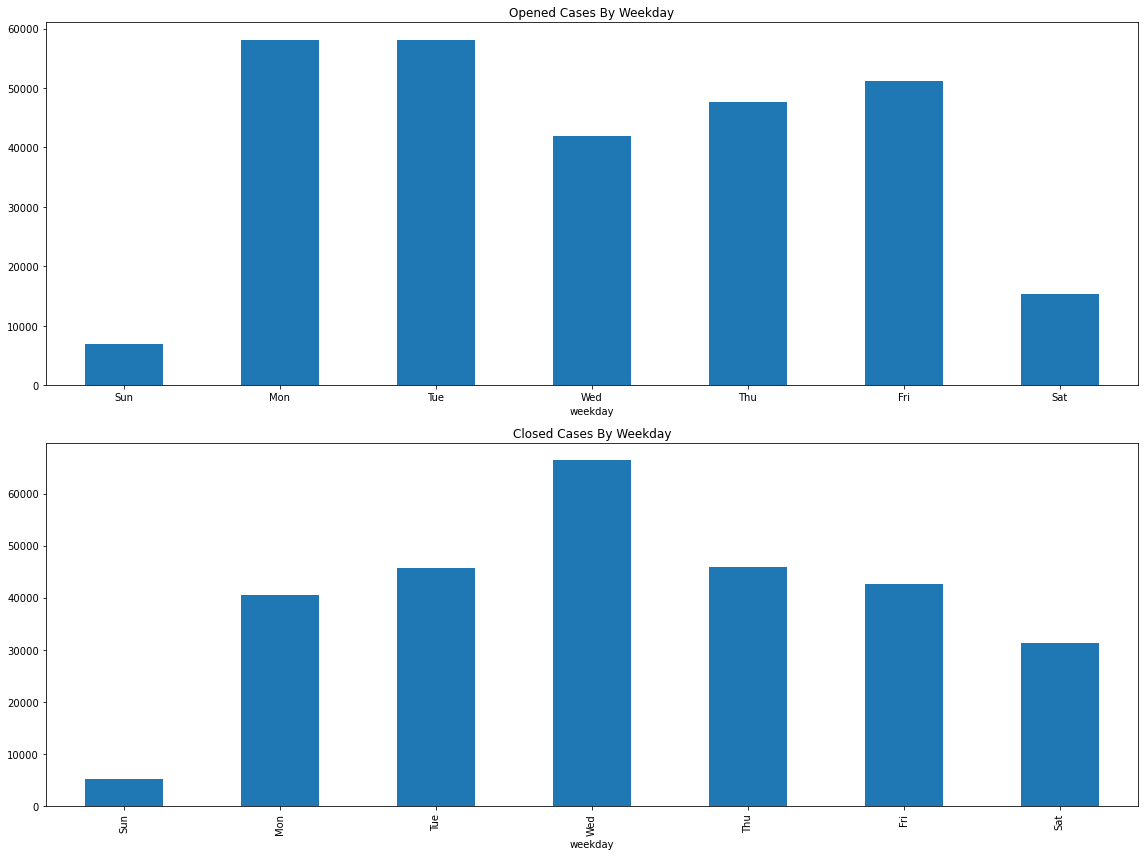

22/02/16 22:56:57 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 910709 ms exceeds timeout 120000 ms
22/02/16 22:56:58 WARN SparkContext: Killing executors is not supported by current scheduler.


In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

(
    df.withColumn("weekday", date_format("case_opened_date", "E"))
    .filter(expr('department == "Solid Waste"'))
    .groupby("weekday")
    .count()
    .na.drop()
    .toPandas()
    .assign(weekday=lambda df: pd.Categorical(df.weekday, categories=weekdays, ordered=True))
    .set_index('weekday')['count']
    .sort_index()
    .plot.bar(ax=ax1)
)
ax1.set(
    title='Opened Cases By Weekday'
)
ax1.tick_params(axis='x', labelrotation=0)


(
    df.withColumn("weekday", date_format("case_closed_date", "E"))
    .filter(expr('department == "Solid Waste"'))
    .groupby("weekday")
    .count()
    .na.drop()
    .toPandas()
    .assign(weekday=lambda df: pd.Categorical(df.weekday, categories=weekdays, ordered=True))
    .set_index('weekday')['count']
    .sort_index()
    .plot.bar(ax=ax2)
)
ax2.set(
    title='Closed Cases By Weekday'
)
fig.tight_layout()